Подготовка:


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
%matplotlib inline
device = torch.device('cuda:0')

Предобработка:

In [ ]:
def get_loader(train, batch_size):
    dataset = datasets.MNIST('mnist', train=train, download=True,
        transform=transforms.ToTensor())
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return loader
    
train = get_loader(True, 64)
val = get_loader(False, 64)

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw


Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw


Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Модель

In [ ]:
model = nn.Sequential(
    nn.Linear(784, 250),
    nn.Dropout(p=0.07),
    nn.ReLU(),
    nn.Linear(250, 16),
    nn.LogSoftmax(dim=1)
)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.NLLLoss()

Функция точности:

In [ ]:
def accuracy(model, val):
    total = 0
    correct = 0
    for X, y in val:
        X = X.to(device)
        y = y.to(device)
        X = X.view(-1, 784)
        res = model(X)
        res = res.argmax(dim=1)
        total += res.shape[0]
        correct += (res == y).sum().item()
    return correct / total

Обучение:

In [ ]:
train_losses = []
for epoch in range(8):
    train_loss = 0
    for data, target in train:
        data = data.to(device)
        target = target.to(device)
        data = data.view(-1, 784)
        
        optimizer.zero_grad()
        
        predict = model(data)
        loss = criterion(predict, target)
        
        loss.backward()

        train_losses.append(loss.item())
        optimizer.step()

    print(f' Номер эпохи: {epoch}, Точность на обучающей: {accuracy(model, train)} Точность на тестовой: {accuracy(model, val)}, ')

 Номер эпохи: 0, Точность на обучающей: 0.9552333333333334 Точность на тестовой: 0.9524, 
 Номер эпохи: 1, Точность на обучающей: 0.97245 Точность на тестовой: 0.9668, 
 Номер эпохи: 2, Точность на обучающей: 0.9786 Точность на тестовой: 0.9701, 
 Номер эпохи: 3, Точность на обучающей: 0.9841 Точность на тестовой: 0.9765, 
 Номер эпохи: 4, Точность на обучающей: 0.9869666666666667 Точность на тестовой: 0.9753, 
 Номер эпохи: 5, Точность на обучающей: 0.98875 Точность на тестовой: 0.9749, 
 Номер эпохи: 6, Точность на обучающей: 0.9915333333333334 Точность на тестовой: 0.9768, 
 Номер эпохи: 7, Точность на обучающей: 0.9928 Точность на тестовой: 0.9786, 


Опишем класс Автоэнкодеров:

In [ ]:
latent_dim = 15
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encode = nn.Sequential(
            nn.Linear(784, 225),
            nn.ReLU(),
            nn.Linear(225, latent_dim)
        )
        
        self.decode = nn.Sequential(
            nn.ReLU(),
            nn.Linear(latent_dim, 225),
            nn.ReLU(),
            nn.Linear(225, 784),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.decode(self.encode(x))

model = Autoencoder()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
for epoch in range(10):
    train_loss = 0
    for data, _ in train:
        data = data.view(-1, 784)
        
        optimizer.zero_grad()
        
        predict = model(data)
        loss = criterion(data, predict)
        
        loss.backward()

        train_loss += loss.item()
        optimizer.step()

    print('epoch %d, loss %.4f' % (epoch, train_loss / len(train)))
      

epoch 0, loss 0.0396
epoch 1, loss 0.0272
epoch 2, loss 0.0254
epoch 3, loss 0.0243
epoch 4, loss 0.0235
epoch 5, loss 0.0230
epoch 6, loss 0.0225
epoch 7, loss 0.0222
epoch 8, loss 0.0219
epoch 9, loss 0.0217


Реализуем морфинг:

In [ ]:
import numpy
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

In [ ]:
def get(x):
    return train.dataset[x][0].view(1, 784)

def imshow(img):
    pic = img.numpy().astype('float')
    plt.axis('off')
    return plt.imshow(pic, cmap='Greys', animated=True)

def morph(inputs, steps, delay):
    latent = [model.encode(get(k)).data for k in inputs]
    fig = plt.figure()
    images = []
    for a, b in zip(latent, latent[1:] + [latent[0]]):
        for t in numpy.linspace(0, 1, steps):
            c = a*(1-t)+b*t
            morphed = model.decode(c).data
            morphed = morphed.view(28, 28)
            images.append([imshow(morphed)])
    
    ani = animation.ArtistAnimation(fig, images, interval=delay)

    display(HTML(ani.to_html5_video()))

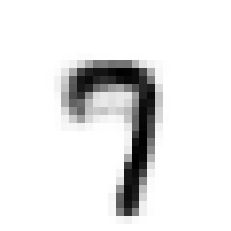

In [ ]:
morph(numpy.random.randint(0, len(train.dataset), 30), 20, 60)

Визуализируем MNIST автоэнкодером:

In [ ]:
latent_dim = 2
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encode = nn.Sequential(
            nn.Linear(784, 230),
            nn.ReLU(),
            nn.Linear(230, latent_dim)
        )
        
        self.decode = nn.Sequential(
            nn.ReLU(),
            nn.Linear(latent_dim, 230),
            nn.ReLU(),
            nn.Linear(230, 784),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.decode(self.encode(x))

model = Autoencoder()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
for epoch in range(10):
    train_loss = 0
    for data, _ in train:
        #data = data.to(device)
        data = data.view(-1, 784)
        
        optimizer.zero_grad()
        
        predict = model(data)
        loss = criterion(data, predict)
        
        loss.backward()

        train_loss += loss.item()
        optimizer.step()

    print('epoch %d, loss %.4f' % (epoch, train_loss / len(train)))

epoch 0, loss 0.0643
epoch 1, loss 0.0562
epoch 2, loss 0.0496
epoch 3, loss 0.0465
epoch 4, loss 0.0451
epoch 5, loss 0.0443
epoch 6, loss 0.0437
epoch 7, loss 0.0433
epoch 8, loss 0.0430
epoch 9, loss 0.0427


In [ ]:
model_encode = model.encode
points1 = []
points2 = []
label = []
for i in range(len(val.dataset)):
    x = val.dataset[i][0].view(-1,784)
    y = val.dataset[i][1]
    point = model_encode(x)
    point = point.detach().numpy()[0]
    points1.append(point[0])
    points2.append(point[1])
    label.append(y)

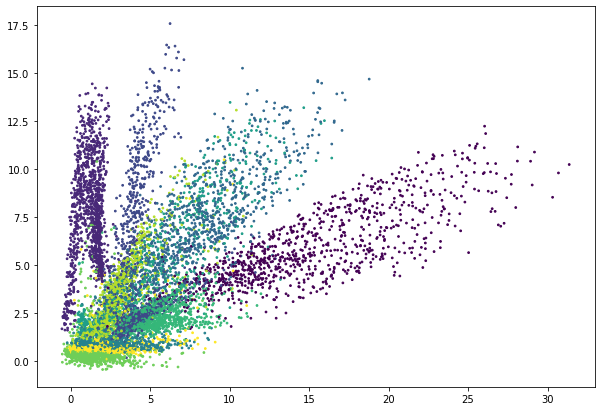

In [ ]:
plt.figure(figsize = (10,7))
plt.scatter(points1, points2, c = label, s = 3)

<Figure size 2160x1080 with 0 Axes>

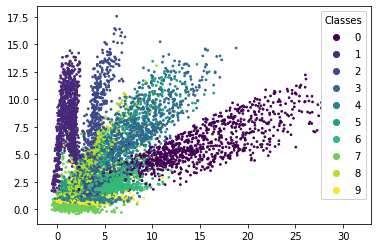

In [ ]:
fig, ax = plt.subplots()
scatter = ax.scatter(points1, points2, c = label, s = 3)
legend = ax.legend(*scatter.legend_elements(), title='Classes')
ax.add_artist(legend)
plt.show()